In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Imports
import itertools
import pickle

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import gc, sys
gc.enable()

# 0) Load
---

In [2]:
folder = '/home/lgriffin/Documents/Jupyter/Kaggle/Data/PUBG/'

train = pd.read_csv(folder+'train_V2.csv')
#test_set = pd.read_csv(folder+'test_V2.csv')
sample = pd.read_csv(folder+'sample_submission_V2.csv')

In [3]:
print('Features: ')
print(train.columns.values)

Features: 
['Id' 'groupId' 'matchId' 'assists' 'boosts' 'damageDealt' 'DBNOs'
 'headshotKills' 'heals' 'killPlace' 'killPoints' 'kills' 'killStreaks'
 'longestKill' 'matchDuration' 'matchType' 'maxPlace' 'numGroups'
 'rankPoints' 'revives' 'rideDistance' 'roadKills' 'swimDistance'
 'teamKills' 'vehicleDestroys' 'walkDistance' 'weaponsAcquired'
 'winPoints' 'winPlacePerc']


# 2) Inspect Data
---

> ## a) Drop entries

In [4]:
#First step: any NaNs??
train[train.isnull().any(axis=1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [5]:
train[train.isnull().any(axis=1)]#Yep, remove it
train.drop(2744604, inplace=True)

>## b) Get a subset

In [6]:
# Get a small subset to make plotting easier/ make it run faster
train.reindex(np.random.permutation(train.index))
subset = train.head(10000)
gc.collect()

105

> ## c) Check correlations

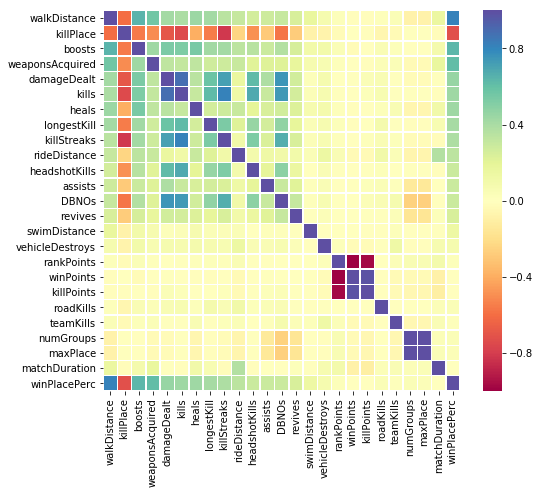

In [7]:
features =  ['walkDistance', 'killPlace', 'boosts'
            ,'weaponsAcquired', 'damageDealt', 'kills', 'heals'
            ,'longestKill', 'killStreaks', 'rideDistance' 
            ,'headshotKills', 'assists', 'DBNOs', 'revives'
            ,'swimDistance', 'vehicleDestroys'
            ,'rankPoints','winPoints', 'killPoints'
            ,'roadKills', 'teamKills'
            ,'numGroups', 'maxPlace','matchDuration'
            ,'winPlacePerc'
            ]

fig = plt.figure(figsize=(8,7))
ax = sns.heatmap(subset[features].corr(), vmin=-1, vmax=1, linewidths=.5, cmap='Spectral')
plt.show()

> ## d) Check the relationships

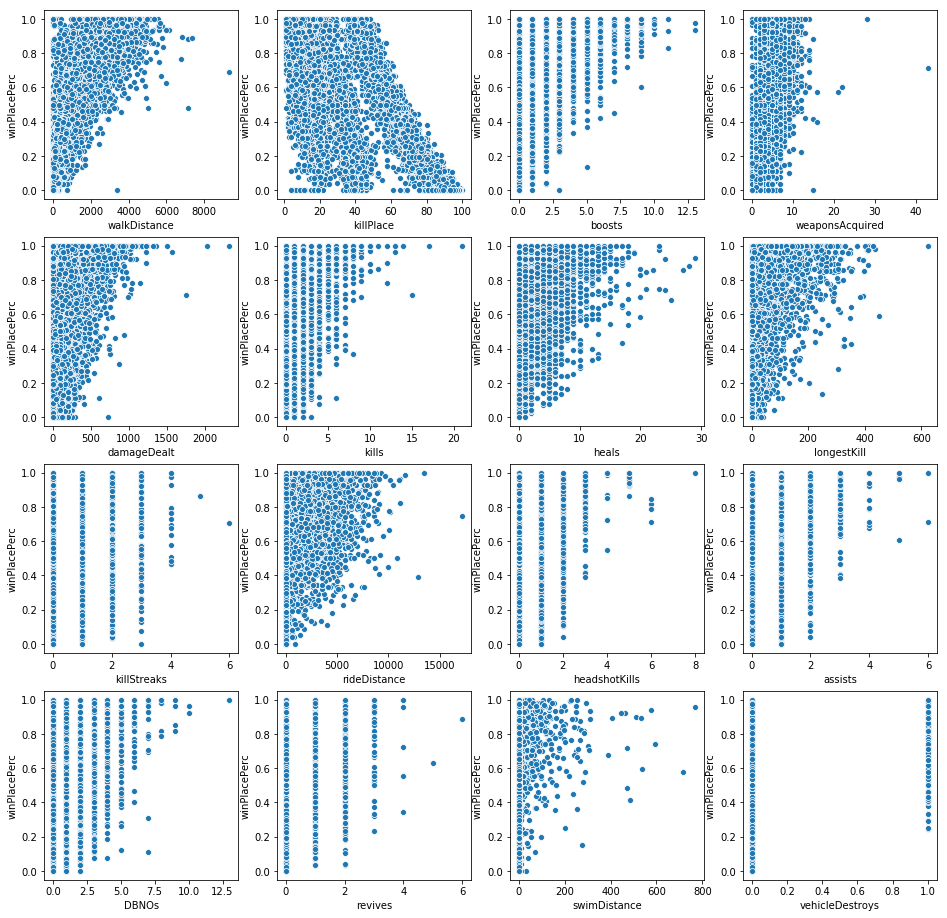

In [8]:
#Lets start by looking at the most strongly correlated (top 16)
features = ['walkDistance', 'killPlace', 'boosts',
       'weaponsAcquired', 'damageDealt', 'kills', 'heals', 'longestKill',
       'killStreaks', 'rideDistance', 'headshotKills', 'assists', 'DBNOs',
       'revives', 'swimDistance', 'vehicleDestroys',]

target = 'winPlacePerc'

i = 1

#What do these relationships actually look like???
fig = plt.figure(figsize=(16,16))
for feat in features:
    ax = plt.subplot(4,4,i)
    ax = sns.scatterplot(x=subset[feat], y=subset[target])
    ax.set(xlabel=feat, ylabel=target)
    i=i+1
plt.show()

For these features, a linear model could be a pretty good fit!

# 3) Feature Engineering
***

>## a) Create some new features

In [9]:
#walkDistance divided matchDuration might give a "avg speed" kind of information
tempFrame = train.loc[:,['walkDistance','winPlacePerc', 'matchDuration']]
tempFrame['avgVelocity'] = train['walkDistance']/train['matchDuration']
tempFrame.corr()

,walkDistance,winPlacePerc,matchDuration,avgVelocity
walkDistance,1.000000,0.810888,0.145062,0.973437
winPlacePerc,0.810888,1.000000,-0.005171,0.824374
matchDuration,0.145062,-0.005171,1.000000,-0.015843
avgVelocity,0.973437,0.824374,-0.015843,1.000000


avgVelocity gives a a bit more info! But is highly correlated with walkDistance.
Add avgVelocity but remove walkDistance

I am borrowing some of these features: headShotRate, killStreakRate, kills_assists


from a great kernel:
https://www.kaggle.com/chocozzz/pubg-data-description-a-to-z-fe-with-python

In [10]:
#headshotRate informs on how accurate a player is or how efficient their shooting is
tempFrame = train.loc[:,['kills','winPlacePerc', 'headshotKills']]
tempFrame['headshotRate'] = train['kills']/train['headshotKills']
tempFrame.corr()

,kills,winPlacePerc,headshotKills,headshotRate
kills,1.000000,0.419916,0.674275,0.678770
winPlacePerc,0.419916,1.000000,0.277722,0.323687
headshotKills,0.674275,0.277722,1.000000,-0.082599
headshotRate,0.678770,0.323687,-0.082599,1.000000


In [11]:
tempFrame = train.loc[:,['kills','winPlacePerc', 'killStreaks']]
tempFrame['killStreakRate'] = train['killStreaks']/train['kills']
tempFrame.corr()

,kills,winPlacePerc,killStreaks,killStreakRate
kills,1.000000,0.419916,0.802500,-0.730883
winPlacePerc,0.419916,1.000000,0.377566,-0.386675
killStreaks,0.802500,0.377566,1.000000,-0.143883
killStreakRate,-0.730883,-0.386675,-0.143883,1.000000


In [12]:
tempFrame = train.loc[:,['assists','winPlacePerc', 'kills']]
tempFrame['kills_assists'] = train['assists']+train['kills']
tempFrame.corr()

,assists,winPlacePerc,kills,kills_assists
assists,1.000000,0.299441,0.319690,0.592749
winPlacePerc,0.299441,1.000000,0.419916,0.453051
kills,0.319690,0.419916,1.000000,0.952618
kills_assists,0.592749,0.453051,0.952618,1.000000


Better than kills, but highly correlated with kills. Add kills_assists and drop kills

In [13]:
del tempFrame, subset
gc.collect()

6867

>## b) Rank data

winPlacePerc is effectivley a measurement of a groups ability as compared to the other groups *in the match*.

What if we look at the features according to matchId and group, furthermore, we can rank the them according to match?? Might improve predictive power.

Lets start by looking at group mean, min, max, as well as the rank of these features.

Also, create match mean and size features


Note: This approach is adapted from: https://www.kaggle.com/anycode/simple-nn-baseline-4

In [14]:
def preprocess_data(dataframe, target = 'winPlacePerc'):
    
    #get a list of featuress, remove the uncessary ones
    features = list(dataframe.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    features.remove("walkDistance")
    features.remove("kills")
    features.remove(target)
    
    #Add some new features
    dataframe.loc[:,'avgVelocity'] = dataframe.loc[:,'walkDistance']/dataframe.loc[:,'matchDuration']
    dataframe.loc[:,'headshotRate'] = dataframe.loc[:,'kills']/dataframe.loc[:,'headshotKills']
    dataframe.loc[:,'killStreakRate'] = dataframe.loc[:,'killStreaks']/dataframe.loc[:,'kills']
    dataframe.loc[:,'kills_assists'] = dataframe.loc[:,'assists']+dataframe.loc[:,'kills']
    
    dataframe['headshotRate'] = dataframe['headshotRate'].apply(lambda x: 0 if x == np.inf else x)
    dataframe['killStreakRate'] = dataframe['killStreakRate'].apply(lambda x: 0 if x == np.inf else x)
    
    #don't forget to fill nan's with zeros, these nan's are due to headshotRate being kills/headshots
    #dataframe.fillna(0)
    
    #Add these new features to the feature list
    features.append('avgVelocity')
    features.append('killStreakRate')
    features.append('headshotRate')
    features.append('kills_assists')
    
    #Get the group means and rank them according to match
    #also get the target values
    print("Get group mean feature")
    grouped = dataframe.groupby(['matchId','groupId'])
    y = grouped[target].agg('mean').reset_index()
    agg = grouped[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    df_out = agg.reset_index()[['matchId','groupId']]
    
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
        
    print("Get group max feature")
    agg = dataframe.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Get group min feature")
    agg = dataframe.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("Get match mean feature")
    agg = dataframe.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = dataframe.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    #Merge these new features with the original features
    df_out = df_out.merge(y, suffixes=["", target], how='left', on=['matchId', 'groupId'])
    gc.collect()
    
    return df_out

In [15]:
train = preprocess_data(train)

Get group mean feature
Get group max feature
Get group min feature
Get match mean feature
get match size feature


> ## c) Scale Data

In [16]:
#scale down the features according to number of deviations away from the mean
def scale_features(dataframe, features):
    dataframe[features] = dataframe[features].apply(lambda x: (x - x.mean())/(x.std()))

In [18]:
scale_these = ['assists_mean', 'boosts_mean',
       'damageDealt_mean', 'DBNOs_mean', 'headshotKills_mean',
       'heals_mean', 'killPlace_mean', 'killPoints_mean',
       'killStreaks_mean', 'longestKill_mean', 'matchDuration_mean',
       'maxPlace_mean', 'numGroups_mean', 'rankPoints_mean',
       'revives_mean', 'rideDistance_mean', 'roadKills_mean',
       'swimDistance_mean', 'teamKills_mean', 'vehicleDestroys_mean',
       'weaponsAcquired_mean', 'winPoints_mean', 'avgVelocity_mean',
       'killStreakRate_mean', 'headshotRate_mean', 'kills_assists_mean',
       'assists_max', 'boosts_max',
       'damageDealt_max', 'DBNOs_max', 'headshotKills_max', 'heals_max',
       'killPlace_max', 'killPoints_max', 'killStreaks_max',
       'longestKill_max', 'matchDuration_max', 'maxPlace_max',
       'numGroups_max', 'rankPoints_max', 'revives_max',
       'rideDistance_max', 'roadKills_max', 'swimDistance_max',
       'teamKills_max', 'vehicleDestroys_max', 'weaponsAcquired_max',
       'winPoints_max', 'avgVelocity_max', 'killStreakRate_max',
       'headshotRate_max', 'kills_assists_max', 
       'assists_min', 'boosts_min',
       'damageDealt_min', 'DBNOs_min', 'headshotKills_min', 'heals_min',
       'killPlace_min', 'killPoints_min', 'killStreaks_min',
       'longestKill_min', 'matchDuration_min', 'maxPlace_min',
       'numGroups_min', 'rankPoints_min', 'revives_min',
       'rideDistance_min', 'roadKills_min', 'swimDistance_min',
       'teamKills_min', 'vehicleDestroys_min', 'weaponsAcquired_min',
       'winPoints_min', 'avgVelocity_min', 'killStreakRate_min',
       'headshotRate_min', 'kills_assists_min',
       'assists', 'boosts', 'damageDealt',
       'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints',
       'killStreaks', 'longestKill', 'matchDuration', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'weaponsAcquired',
       'winPoints', 'avgVelocity', 'killStreakRate', 'headshotRate',
       'kills_assists']

scale_features(train, scale_these)

In [19]:
train = train.fillna(0)

In [20]:
#Get a subset for training, to make it quicker
#just trying to get an idea here!
train.reindex(np.random.permutation(train.index))
train = train.head(10000)
gc.collect()

96

# 3) Model - RBF SVR
---

In [22]:
#----- Select Features
target = 'winPlacePerc'

features = list(train.columns.values)
#features.remove("Id")
features.remove("matchId")
features.remove("groupId")
#features.remove("walkDistance")
#features.remove("kills")
features.remove(target)

#----- Model
model = NuSVR(kernel='rbf', C=0.9, nu=1)

#----- Train and Validate
xvals = train[features]
yvals = train[target]

#Use a simple 25% hold out for validation
x_train, x_valid, y_train, y_valid = train_test_split(xvals, 
                                                      yvals, test_size=0.25)  

fitted = model.fit(x_train, y_train)
y_valid_predict = fitted.predict(x_valid)
print('R2: ', fitted.score(x_valid, y_valid))
print('MSE: ', mean_squared_error(y_valid, y_valid_predict))
print('MAE: ', mean_absolute_error(y_valid, y_valid_predict))

R2:  0.9368148460925615
MSE:  0.005699111227622136
MAE:  0.04460890402688949
